In [14]:
%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from protest_impact.data.news.coverage_filter import filter_protests
from protest_impact.data.protests.random import get_random_events

random_events = get_random_events(200, seed=0)
random_events = filter_protests(random_events, source="mediacloud")

In [39]:
from protest_impact.synthetic_region import (
    evaluate_multiple_protests,
    get_regional_counts_for_protest,
    predict_with_lasso,
    predict_with_linear_regression,
    synthetic_region,
)


def evaluate(method, n_days_train):
    metrics, df, agg_df = evaluate_multiple_protests(
        "klima*",
        random_events,
        source="mediacloud",
        data_kwargs=dict(
            n_days_train=n_days_train,
            n_days_predict=7 * 2,
            n_days_protest_free_pre=0,
            n_days_protest_free_post=0,
            min_control_regions=1,
            min_count=3,
        ),
        method_kwargs=dict(
            method=method,
        ),
    )
    return metrics, df, agg_df

### Baseline

Lasso, which is biased.


In [40]:
metrics, dfs, agg_df = evaluate(predict_with_lasso, None)

  0%|          | 0/161 [00:00<?, ?it/s]

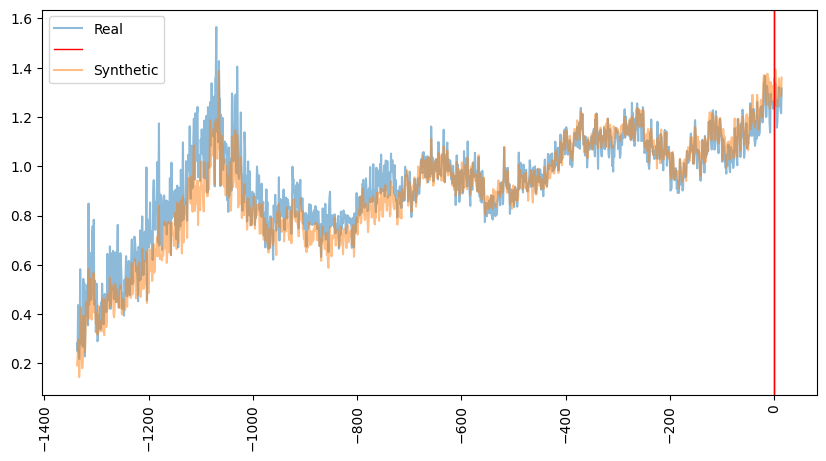

In [41]:
import matplotlib.pyplot as plt
from protest_impact.data.discourse.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 5))
plot_coverage_sequence(agg_df.rename(columns={"real": "count"}), ax=ax, protest_date=0)
plot_coverage_sequence(agg_df.rename(columns={"synth": "count"}), ax=ax, protest_date=0)
ax.legend(["Real", "", "Synthetic"])

In [19]:
event = random_events.iloc[1]

In [20]:
df = get_regional_counts_for_protest(
    "klima*",
    event,
    random_events,
    source="mediacloud",
    n_days_train=7 * 4 * 12,
    n_days_predict=7 * 2,
    n_days_protest_free_pre=0,
    n_days_protest_free_post=0,
    min_control_regions=1,
    min_count=3,
)

In [21]:
metrics, _, count_df = synthetic_region(df, event, method=predict_with_lasso)

In [22]:
metrics["mse"]

0.039831715762246075

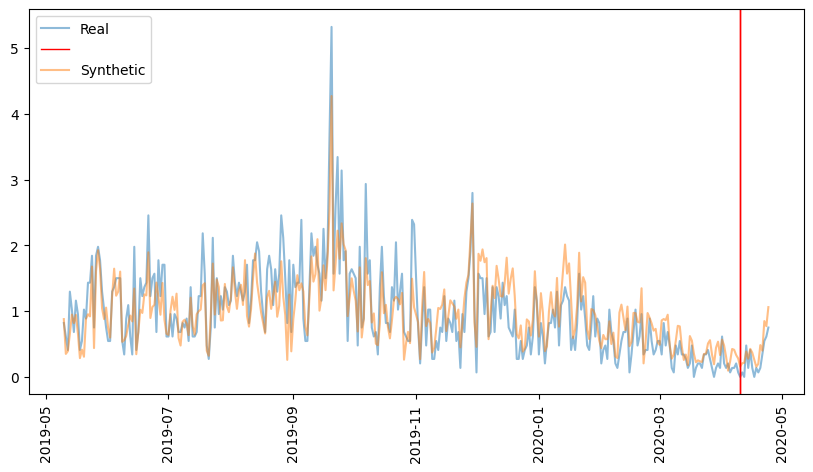

In [23]:
import matplotlib.pyplot as plt
from protest_impact.data.discourse.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 5))
plot_coverage_sequence(
    count_df.rename(columns={"real": "count"}), ax=ax, protest_date=event["event_date"]
)
plot_coverage_sequence(
    count_df.rename(columns={"synth": "count"}), ax=ax, protest_date=event["event_date"]
)
ax.legend(["Real", "", "Synthetic"])

### GAMs tutorial

In [24]:
from pygam import LinearGAM, f, s
from pygam.datasets import wage

X, y = wage(return_X_y=True)

In [25]:
X.shape, y.shape

((3000, 3), (3000,))

In [26]:
import pandas as pd

pd.DataFrame(X).describe()

,0,1,2
count,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,2.010000
std,2.026167,11.542406,1.215618
min,2003.000000,18.000000,0.000000
25%,2004.000000,33.750000,1.000000
50%,2006.000000,42.000000,2.000000
75%,2008.000000,51.000000,3.000000
max,2009.000000,80.000000,4.000000


In [27]:
gam = LinearGAM(s(0) + s(1) + f(2))
gam

LinearGAM(callbacks=['deviance', 'diffs'], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2), tol=0.0001, 
   verbose=False)

In [28]:
gam.gridsearch(X, y)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [29]:
import numpy as np

print(np.array2string(X, precision=2, suppress_small=True))

[[2006.   18.    0.]
 [2004.   24.    3.]
 [2003.   45.    2.]
 ...
 [2005.   27.    0.]
 [2005.   27.    2.]
 [2009.   55.    1.]]


In [30]:
XX = gam.generate_X_grid(term=2, n=500)
print(np.array2string(XX, precision=2))

[[ 0.    0.   -0.5 ]
 [ 0.    0.   -0.49]
 [ 0.    0.   -0.48]
 ...
 [ 0.    0.    4.48]
 [ 0.    0.    4.49]
 [ 0.    0.    4.5 ]]


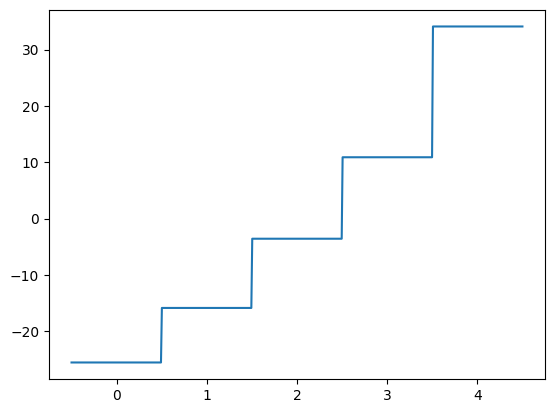

In [31]:
plt.plot(XX[:, 2], gam.partial_dependence(term=2, X=XX))

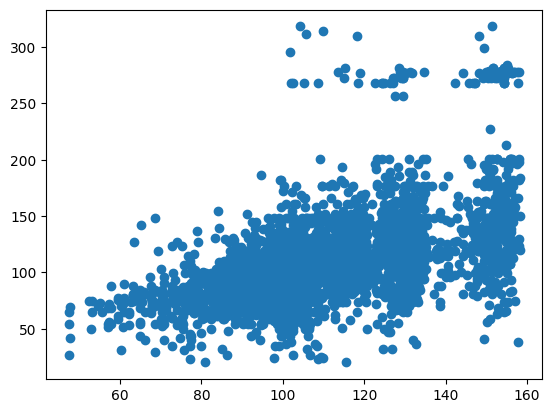

In [32]:
pred = gam.predict(X)
plt.scatter(pred, y)

### GAMs


In [33]:
import pandas as pd
from protest_impact.synthetic_region import train_test_split
from pygam import LinearGAM, f, s
from pygam.terms import TermList
from sklearn.metrics import mean_squared_error


def predict_with_gam(df, protest_region, protest_date):
    """
    df: df in pivoted form, with regions as columns and dates as index
    """
    X_train, Y_train, X_test, Y_test = train_test_split(
        df, protest_region, protest_date
    )
    gam = LinearGAM(TermList(*[s(i) for i in range(X_train.shape[1])]))
    gam.gridsearch(X_train.values, Y_train)
    Y_pred = gam.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    Y_pred_all = gam.predict(pd.concat([X_train, X_test]))
    return mse, Y_pred_all, gam

In [34]:
metrics, model, count_df = synthetic_region(df, event, method=predict_with_gam)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:05
 18% (2 of 11) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:05
 27% (3 of 11) |######                   | Elapsed Time: 0:00:01 ETA:   0:00:04
 36% (4 of 11) |#########                | Elapsed Time: 0:00:02 ETA:   0:00:04
 45% (5 of 11) |###########              | Elapsed Time: 0:00:03 ETA:   0:00:03
 54% (6 of 11) |#############            | Elapsed Time: 0:00:03 ETA:   0:00:03
 63% (7 of 11) |###############          | Elapsed Time: 0:00:04 ETA:   0:00:02
 72% (8 of 11) |##################       | Elapsed Time: 0:00:04 ETA:   0:00:01
 81% (9 of 11) |####################     | Elapsed Time: 0:00:05 ETA:   0:00:01
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:05 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


In [35]:
metrics["mse"]

0.04120185516635528

spline_term


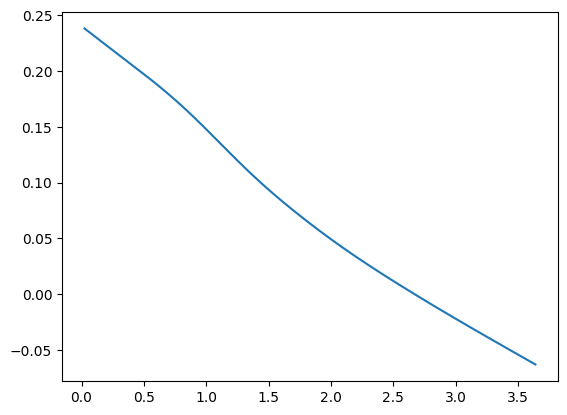

spline_term


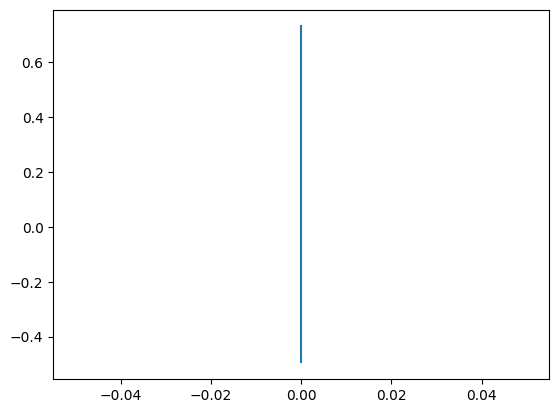

spline_term


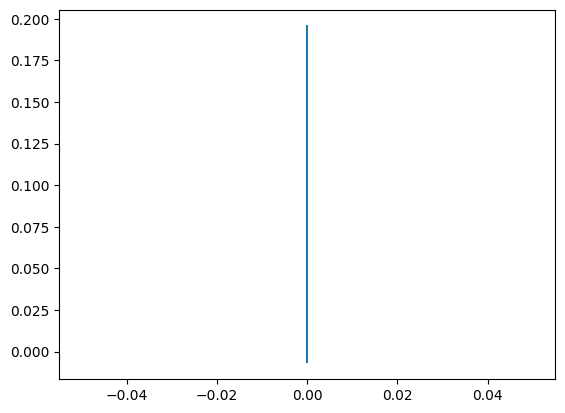

spline_term


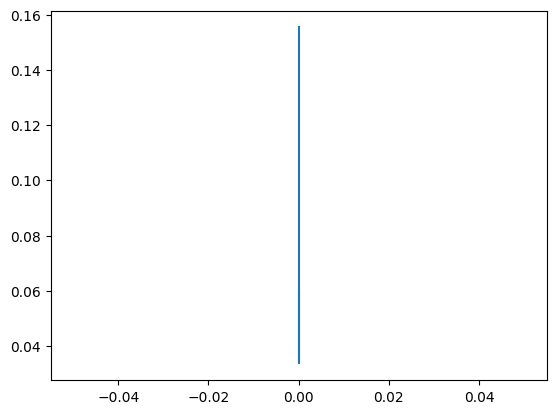

spline_term


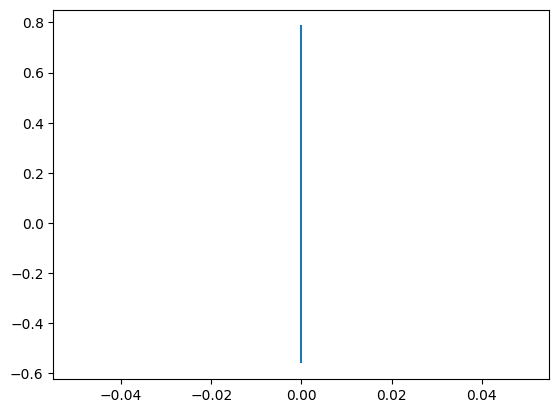

spline_term


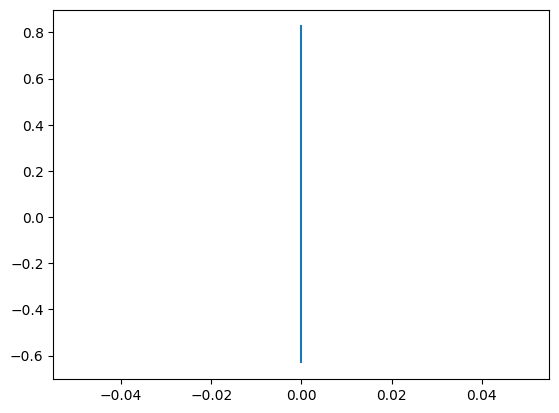

spline_term


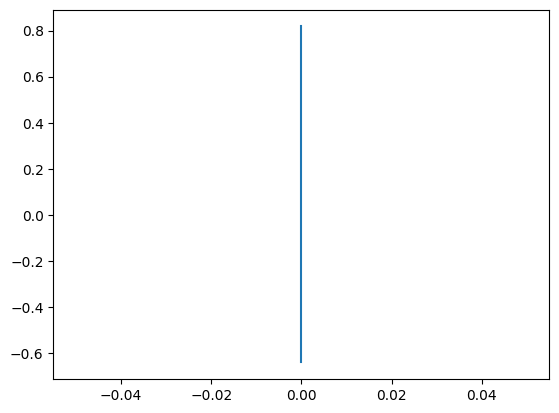

spline_term


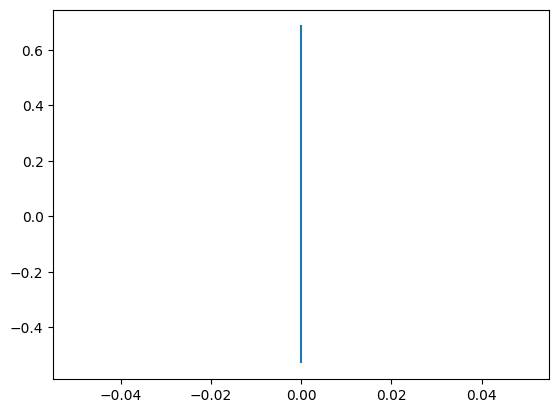

spline_term


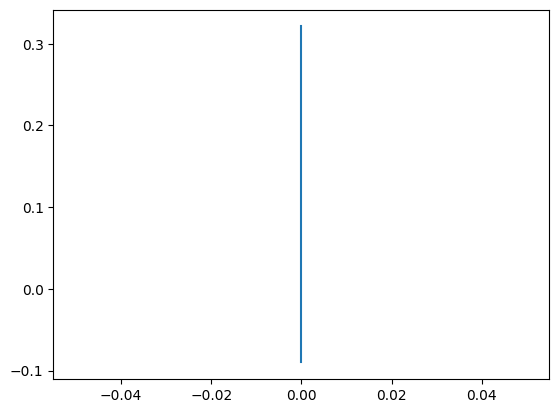

spline_term


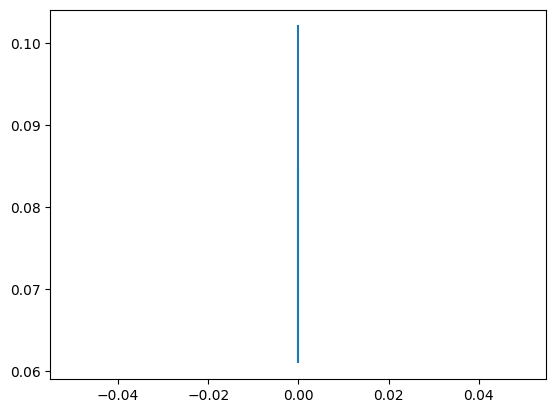

spline_term


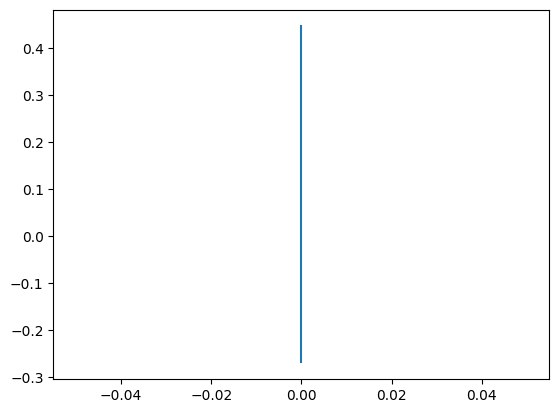

In [36]:
for i in range(len(model.terms) - 1):
    # print(count_df.columns[i])
    print(model.terms[i])
    XX = model.generate_X_grid(term=i, n=500)
    plt.plot(XX[:, 0], model.partial_dependence(term=i, X=XX))
    plt.show()

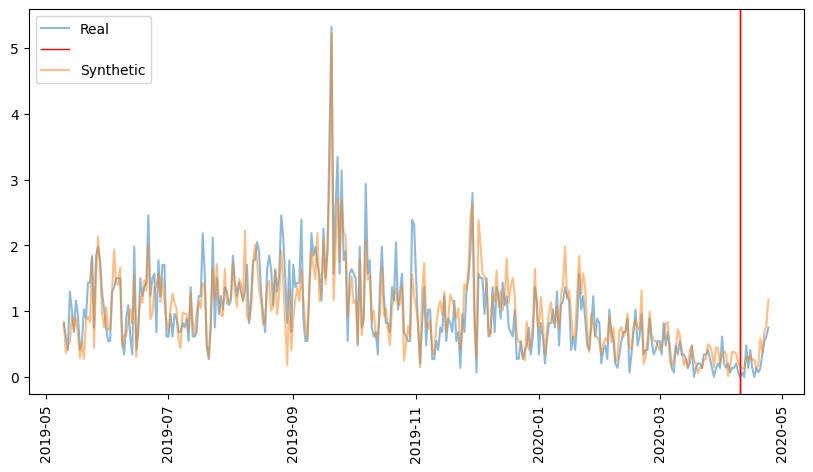

In [37]:
# visualize predictions
fig, ax = plt.subplots(figsize=(10, 5))
plot_coverage_sequence(
    count_df.rename(columns={"real": "count"}), ax=ax, protest_date=event["event_date"]
)
plot_coverage_sequence(
    count_df.rename(columns={"synth": "count"}), ax=ax, protest_date=event["event_date"]
)
ax.legend(["Real", "", "Synthetic"])

In [ ]:
metrics, dfs, agg_df = evaluate(predict_with_gam, None)

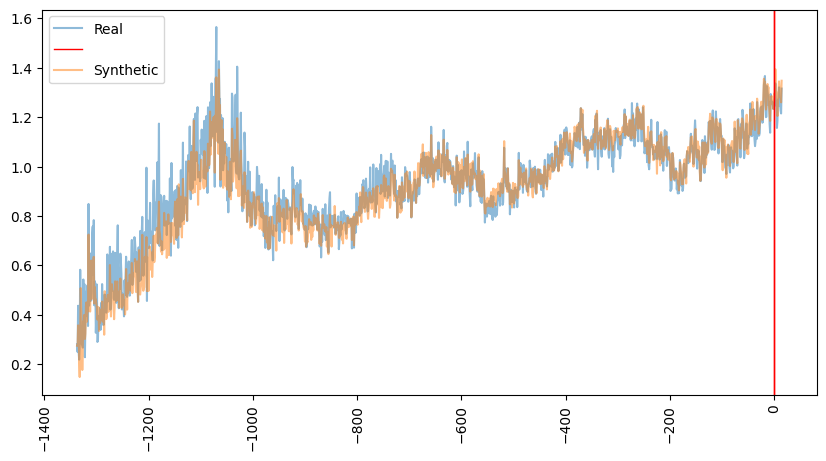

In [ ]:
import matplotlib.pyplot as plt
from protest_impact.data.discourse.visual import plot_coverage_sequence

fig, ax = plt.subplots(figsize=(10, 5))
plot_coverage_sequence(agg_df.rename(columns={"real": "count"}), ax=ax, protest_date=0)
plot_coverage_sequence(agg_df.rename(columns={"synth": "count"}), ax=ax, protest_date=0)
ax.legend(["Real", "", "Synthetic"])